In [1]:
import sys

import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Plotting
from shapely.geometry import Polygon, Point
import geopandas as gpd
from geopandas import GeoDataFrame

import squarify 

import joypy


# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings(action="ignore")

# import xgboost as xgb

In [2]:
# import the datasets
df_details = pd.read_csv('Data/Hotel_details.csv')

df_attr = pd.read_csv('Data/Hotel_Room_attributes.csv')

# df_price_min_max = pd.read_csv('Data/Hotel_price_min_max - Formula.csv')

df_price = pd.read_csv('Data/Hotels_RoomPrice.csv')

In [3]:
# drop the useless features
df_details = df_details.drop(columns=['address', 'zipcode', 'url','curr'])

df_attr = df_attr.drop_duplicates()

df_price = df_price[['id','ispromo','maxoccupancy','israteperstay',
                     'ratetype','discount','onsiterate']]

# add the hotel details to the room attribute dataframe
df1 = pd.merge(df_attr, 
               df_details, 
               left_on='hotelcode', 
               right_on='hotelid', 
               how='left').drop(columns =['hotelid', 'id_y'])

# add room pricing information to the room attribute info
df2 = pd.merge(df1, df_price, 
               left_on='id_x', 
               right_on='id', 
               how='left').drop(columns = 'id')

# change the price attribute's name
new_columns = list(df2.columns.values)

# target label would be the estimating label
new_columns[0] = 'room_id'
new_columns[-1] = 'price' 

df2.columns = new_columns 

In [4]:
# display the final training dataset

df2.sort_values(by=['room_id']).head(20)

,room_id,hotelcode,roomamenities,roomtype,ratedescription,hotelname,city,country,propertytype,starrating,latitude,longitude,Source,ispromo,maxoccupancy,israteperstay,ratetype,discount,price
2,50643430,8323442,Air conditioning: ;Closet: ;Dishwasher: ;Firep...,Vacation Home,"Shower, Kitchenette, 2 bedrooms, 1 double bed ...",Willow Cottage,Beverley,United Kingdom,Hotels,3,53.843220,-0.497970,5,N,4,Y,Extra low price! (non-refundable),0.00,591.74
3,50650317,7975,Air conditioning: ;Clothes rack: ;Coffee/tea m...,Standard Triple Room,"Room size: 20 m²/215 ft², Shower, 3 single beds",Apollo Hotel London,London,United Kingdom,Hotels,2,51.511234,-0.185117,5,N,1,Y,Extra low price! (non-refundable),0.00,881.48
4,50650318,7975,Air conditioning: ;Clothes rack: ;Coffee/tea m...,Standard Triple Room,"Room size: 20 m²/215 ft², Shower, 3 single beds",Apollo Hotel London,London,United Kingdom,Hotels,2,51.511234,-0.185117,5,N,3,Y,Extra low price! (non-refundable),0.00,897.53
5,50650319,7975,Air conditioning: ;Clothes rack: ;Coffee/tea m...,Standard Triple Room,"Room size: 20 m²/215 ft², Shower, 3 single beds",Apollo Hotel London,London,United Kingdom,Hotels,2,51.511234,-0.185117,5,N,3,Y,"Free cancellation before December 26, 2019",0.00,1055.92
6,50650320,7975,Air conditioning: ;Clothes rack: ;Heating: ;In...,Deluxe Triple Room,"Shower, 1 single bed and 1 double bed",Apollo Hotel London,London,United Kingdom,Hotels,2,51.511234,-0.185117,5,N,3,Y,Extra low price! (non-refundable),0.00,897.53
7,50650321,7975,Air conditioning: ;Clothes rack: ;Heating: ;In...,Deluxe Triple Room,"Shower, 1 single bed and 1 double bed",Apollo Hotel London,London,United Kingdom,Hotels,2,51.511234,-0.185117,5,N,3,Y,"Free cancellation before December 26, 2019",0.00,1055.92
1,50672149,8328096,Air conditioning: ;Closet: ;Fireplace: ;Free W...,Vacation Home,"Shower, Kitchenette, 2 bedrooms, 1 double bed ...",Pantlleni,Beddgelert,United Kingdom,Hotels,3,53.042229,-4.033180,5,N,4,Y,Cancellation policy,0.00,636.09
0,50677497,634876,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Double Room,"Room size: 15 m²/161 ft², Shower, 1 king bed",The Old Cider House,Nether Stowey,United Kingdom,Hotels,4,51.150921,-3.158470,5,Y,1,Y,Cancellation policy,6.24,82.36
8,50677498,634876,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Double Room,"Room size: 15 m²/161 ft², Shower, 1 king bed",The Old Cider House,Nether Stowey,United Kingdom,Hotels,4,51.150921,-3.158470,5,N,2,Y,Cancellation policy,0.00,107.70
9,50677499,634876,Air conditioning: ;Alarm clock: ;Carpeting: ;C...,Deluxe Double Room with Shower,"Room size: 17 m²/183 ft², Shower, 1 queen bed ...",The Old Cider House,Nether Stowey,United Kingdom,Hotels,4,51.150921,-3.158470,5,N,2,Y,Extra low price! (non-refundable),0.00,107.70


In [5]:
# print the proportion of missing values in each column
df2.isna().sum()/df2.shape[0]

room_id            0.000000
hotelcode          0.000000
roomamenities      0.029264
roomtype           0.000000
ratedescription    0.029264
hotelname          0.000000
city               0.000000
country            0.000000
propertytype       0.000000
starrating         0.000000
latitude           0.000000
longitude          0.000000
Source             0.000000
ispromo            0.000000
maxoccupancy       0.000000
israteperstay      0.000000
ratetype           0.029264
discount           0.000000
price              0.000000
dtype: float64

In [6]:
# drop the rows with missing values due to their modest proportion
df2 = df2.dropna().reset_index()
print(df2.shape)

(176106, 20)


##  Geographical interpretation

In [7]:
avg_country = df2[['country','price']].groupby('country').mean()

avg_country = avg_country['price'].to_frame().reset_index()

avg_country.columns = ['name','price']

avg_country = avg_country.replace('Czech Republic', 'Czechia')

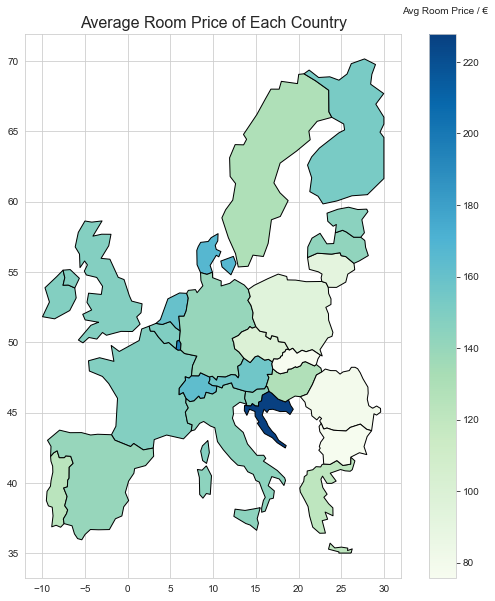

In [8]:
# plt.rcParams["figure.figsize"]=(20,12)
# plt.rcParams["font.size"]=12

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
europe=world[world.continent=="Europe"]
europe=europe[(europe.name!="Russia") & (europe.name!="Iceland")]

polygon = Polygon([(-15,35), (30,35), (30,75),(-15,75)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)

# poly_gdf.plot(edgecolor="red",ax=ax, alpha=0.1)

# Clip polygon from the map of Europe
europe=gpd.clip(europe, polygon)

avg_country_sel=europe[europe.name.isin(list(avg_country.name))]
avg_country_sel=avg_country_sel.merge(avg_country,on='name',how="left")

vmin = avg_country_sel['price'].min()
vmax = avg_country_sel['price'].max()

avg_country_sel.plot('price',cmap="GnBu",
                     edgecolor="black",
                     vmin=vmin,
                     vmax=vmax,figsize=(10, 10))

sm = plt.cm.ScalarMappable(cmap="GnBu", 
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))

# fake up the array of the scalar mappable.
sm._A = []
plt.colorbar(sm).set_label("Avg Room Price / %s"%(u"\N{euro sign}"), 
                           rotation=0,y=1.05, 
                           labelpad=-35)

plt.title("Average Room Price of Each Country",fontdict={'fontsize': 16})

plt.show()

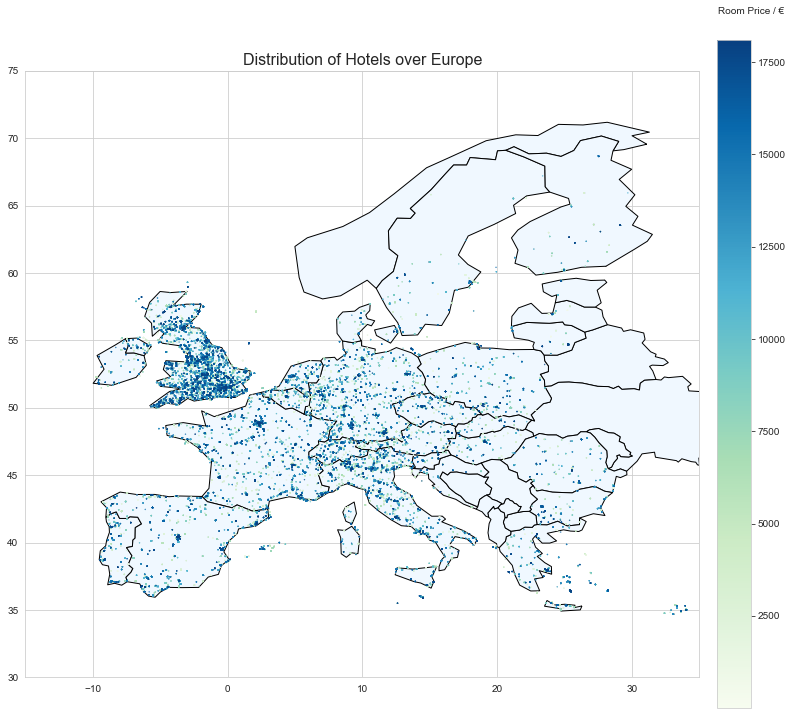

In [9]:
log_lat = df2[['longitude','latitude','price']]

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
europe=world[world.continent=="Europe"]
europe=europe[(europe.name!="Russia") & (europe.name!="Iceland")]

geometry = [Point(xy) for xy in zip(log_lat['longitude'], log_lat['latitude'])]
gdf = GeoDataFrame(log_lat, geometry=geometry)   


ax = europe.plot(figsize=(13, 25), color='aliceblue', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, c =df2['price'], cmap= 'GnBu',markersize=0.15)

ax.set_xlim(-15, 35)
ax.set_ylim(30, 75)

vmin = df2['price'].min()
vmax = df2['price'].max()

plt.title("Distribution of Hotels over Europe",
          fontdict={'fontsize': 16})

sm = plt.cm.ScalarMappable(cmap="GnBu", 
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))

# fake up the array of the scalar mappable.
sm._A = []
# plt.colorbar(sm).set_label("Avg Room Price / %s"%(u"\N{euro sign}"), rotation=0)

plt.colorbar(sm,fraction=0.046, pad=0.025).set_label("Room Price / %s"%(u"\N{euro sign}"), 
                                                     rotation=0,
                                                     y=1.05, 
                                                     labelpad=-35)

plt.show()

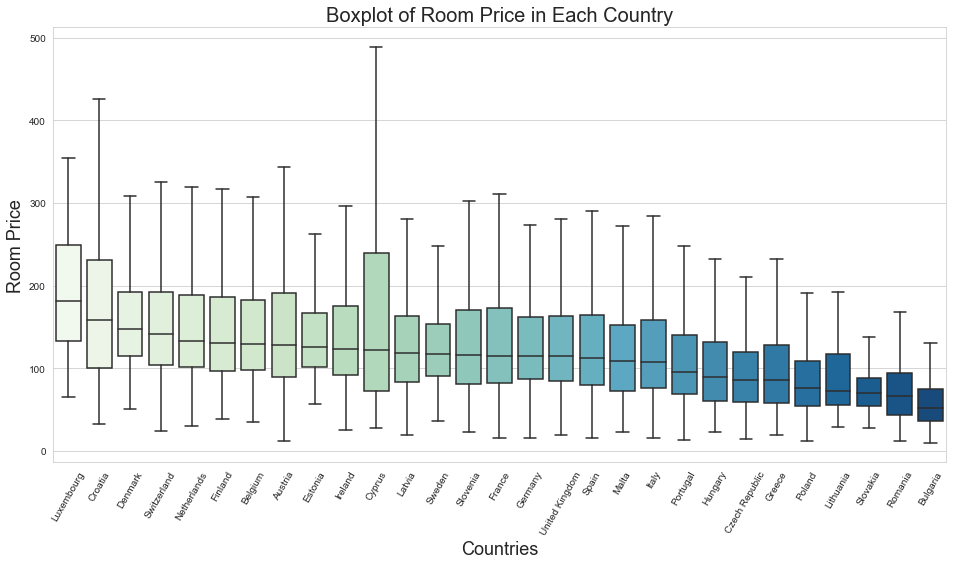

In [10]:
plt.figure(figsize=(16, 8))

avg_cities = df2[['country','city','price']]

# order the countries by their median price
my_order = avg_cities.groupby(by=["country"])["price"].median().sort_values(ascending = False).index

ax = sns.boxplot(x="country", 
                 y="price", 
                 palette="GnBu",
                 showfliers = False, # ignore the outliers to prevent the graph distortion
                 order=my_order, 
                 data=avg_cities)

plt.title("Boxplot of Room Price in Each Country",fontdict={'fontsize': 20})

plt.xlabel('Countries', fontsize = 18)
plt.ylabel('Room Price', fontsize = 18)

plt.xticks(rotation = 60)

plt.show()

In [11]:
avg_cities = avg_cities.drop(columns = 'city')

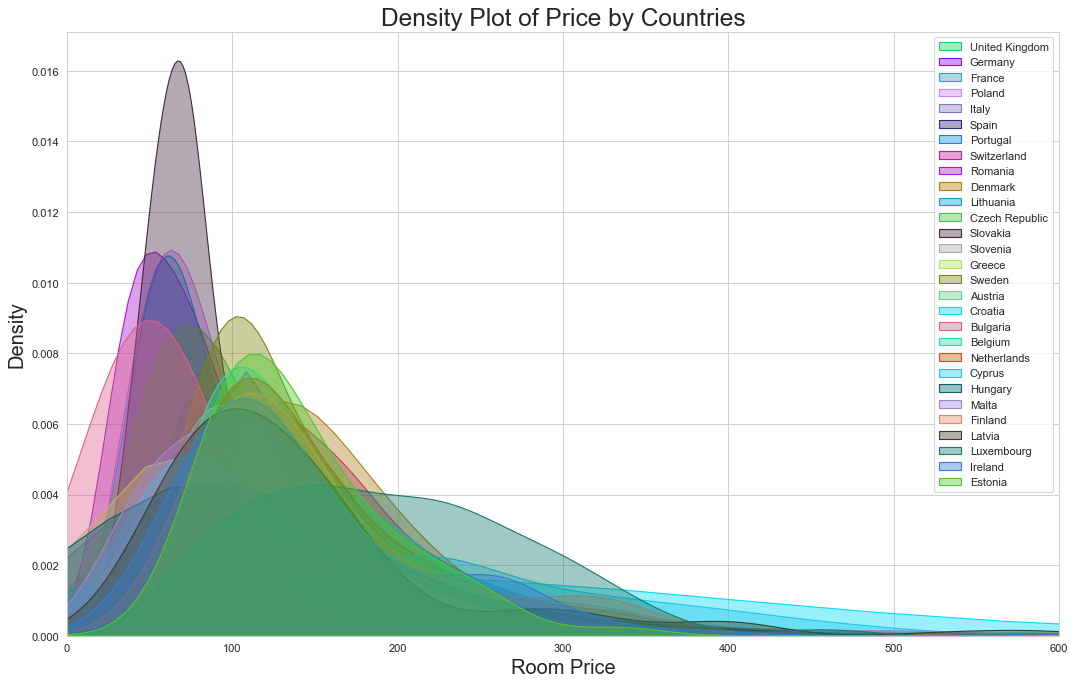

In [12]:
random.seed(123)

color = []
n = len(avg_cities['country'].unique())
for i in range(n):
    color.append('#%06X' % random.randint(0, 0xFFFFFF))

plt.figure(figsize=(16,10), dpi= 80)

for i in range(len(color)):
    # plt.figure()
    country_name = avg_cities['country'].unique()[i]
    sns.kdeplot(avg_cities.loc[avg_cities['country'] == country_name, "price"], 
            shade=True, 
            color=color[i], 
            label=country_name, 
            alpha=.4)


# Decoration
plt.title('Density Plot of Price by Countries', fontsize=22)

plt.ylabel('Density', fontsize = 18)
plt.xlabel('Room Price', fontsize = 18)

plt.xlim(0, 600)

plt.legend()
plt.show()

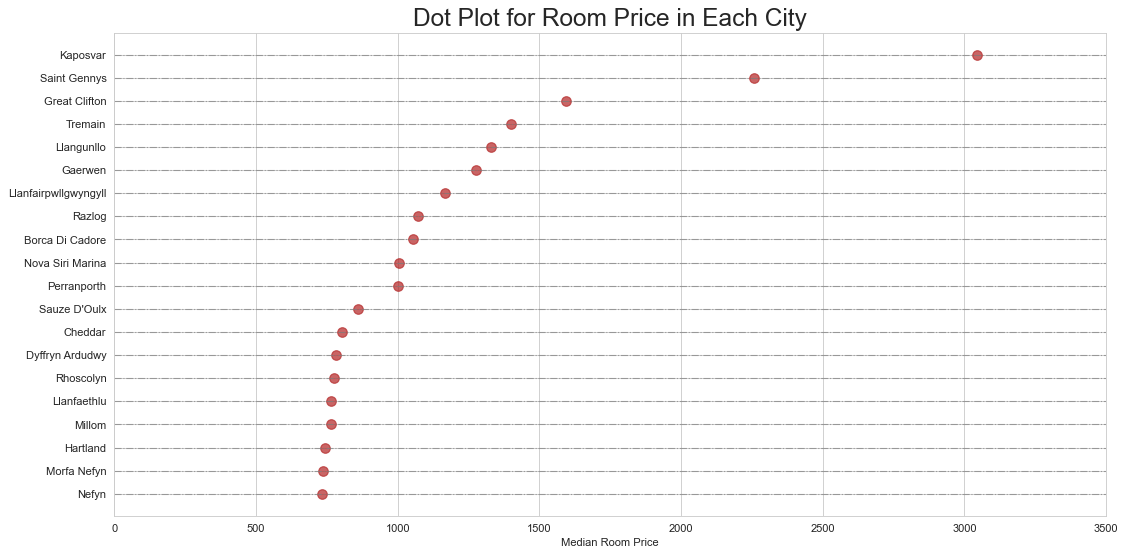

In [13]:
avg_cities = df2[['city','price']].groupby(by=["city"])["price"].median()

# order the countries by their median price
my_order = avg_cities.sort_values(ascending = False).index

avg_cities = avg_cities.sort_values(ascending = False).head(20).sort_values(ascending = True)

fig, ax = plt.subplots(figsize=(16,8), dpi= 80)
ax.hlines(y=avg_cities.index, xmin=0, xmax=3500, color='gray', alpha=0.7, linewidth=1, linestyles='dashdot')
ax.scatter(y=avg_cities.index, x=avg_cities.values, s=75, color='firebrick', alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Dot Plot for Room Price in Each City', fontdict={'size':22})
ax.set_xlabel('Median Room Price')
ax.set_yticks(avg_cities.index)
ax.set_yticklabels(avg_cities.index.str.title(), fontdict={'horizontalalignment': 'right'})
ax.set_xlim(0,3500)
plt.show()

## Room Settings

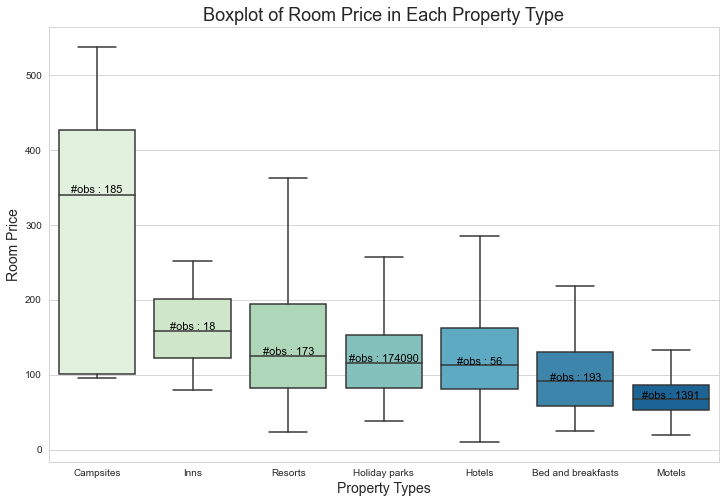

In [14]:
plt.figure(figsize=(12, 8))

# select the target variables
avg_propertytype = df2[['propertytype','price']]

my_order = avg_propertytype.groupby(by=["propertytype"])["price"].median().sort_values(ascending = False).index

ax = sns.boxplot(x = "propertytype", 
                 y = "price",
                 palette = "GnBu",
                 showfliers = False, # ignore the outliers to prevent the graph distortion
                 order = my_order, 
                 data = avg_propertytype)

def add_n_obs(df,group_col,y):
    medians_dict = {grp[0]:grp[1][y].median() for grp in df.groupby(group_col)}
    xticklabels = [x.get_text() for x in plt.gca().get_xticklabels()]
    n_obs = df.groupby(group_col)[y].size().values
    for (x, xticklabel), n_ob in zip(enumerate(xticklabels), n_obs):
        plt.text(x, medians_dict[xticklabel]*1.01, "#obs : "+str(n_ob), 
                 horizontalalignment='center', 
                 fontdict={'size':11}, 
                 color='black')

add_n_obs(avg_propertytype,group_col='propertytype',y='price') 

plt.title("Boxplot of Room Price in Each Property Type",fontdict={'fontsize': 18})

plt.xlabel('Property Types', fontsize = 14)
plt.ylabel('Room Price', fontsize = 14)

plt.show()

In [15]:
top_room_types = df2['roomtype'].value_counts()

top_room_types = top_room_types.loc[top_room_types.values>1000]

# Replace the room types with lower frequency as "Other Types"
df2.loc[(~df2.roomtype.isin(top_room_types.index)),'roomtype']='Other Types'

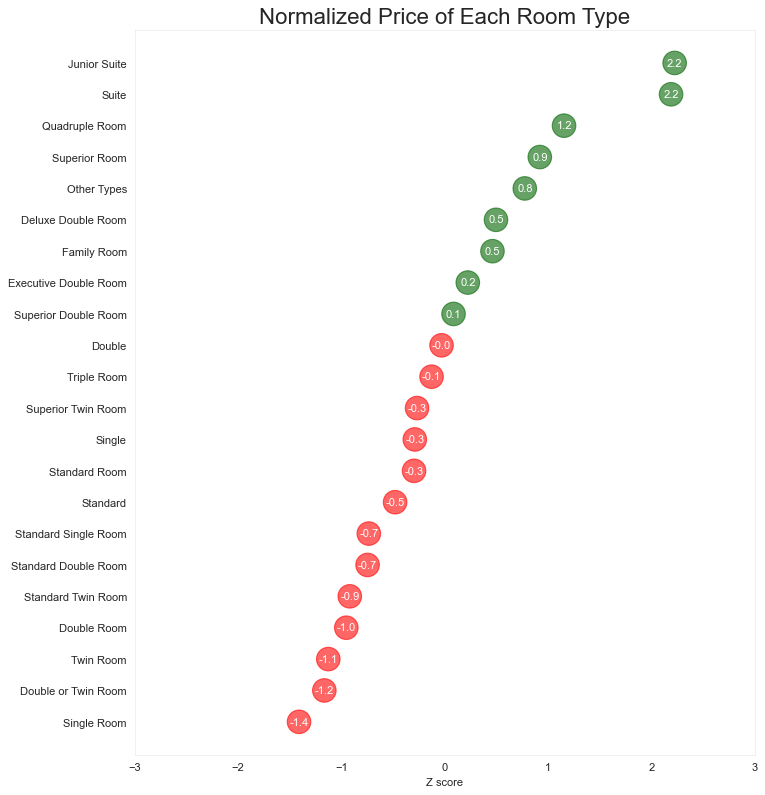

In [16]:
avg_roomtype = df2[['roomtype','price']].groupby('roomtype').mean()

avg_roomtype = avg_roomtype['price'].to_frame().reset_index()

avg_roomtype.columns = ['roomtype','price']

x = avg_roomtype.loc[:, ['price']]

# Calculate the z score of rooms
avg_roomtype['price_z'] = (x - x.mean())/x.std()

avg_roomtype['colors'] = ['red' if x < 0 else 'darkgreen' for x in avg_roomtype['price_z']]
avg_roomtype.sort_values('price_z', inplace=True)
avg_roomtype.reset_index(inplace=True)

# Draw plot
plt.figure(figsize=(10,12), dpi= 80)
plt.scatter(avg_roomtype.price_z, 
            avg_roomtype.roomtype, 
            s=450, 
            alpha=.6, 
            color=avg_roomtype.colors)
for x, y, tex in zip(avg_roomtype.price_z, 
                     avg_roomtype.roomtype, 
                     avg_roomtype.price_z):
    t = plt.text(x, y, round(tex, 1), horizontalalignment='center', 
                 verticalalignment='center', fontdict={'color':'white'})

# Decorations
# Lighten borders
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)

plt.yticks(avg_roomtype.roomtype)
plt.title('Normalized Price of Each Room Type', fontdict={'size':20})
plt.xlabel('Z score')
plt.grid(linestyle='--', alpha=0.5)
plt.xlim(-3, 3)
plt.show()


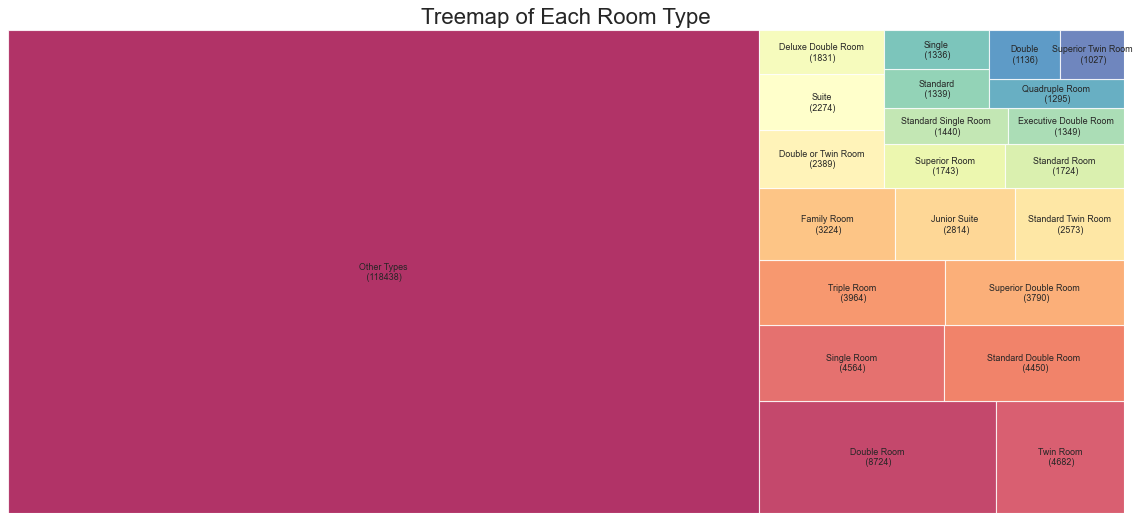

In [17]:
count_roomytype = df2['roomtype'].value_counts().to_frame().reset_index()

labels = count_roomytype.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = count_roomytype['roomtype'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(18,8), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8,text_kwargs={'fontsize':8})

# Decorate
plt.title('Treemap of Each Room Type', fontdict={'size':20})
plt.axis('off')
plt.show()

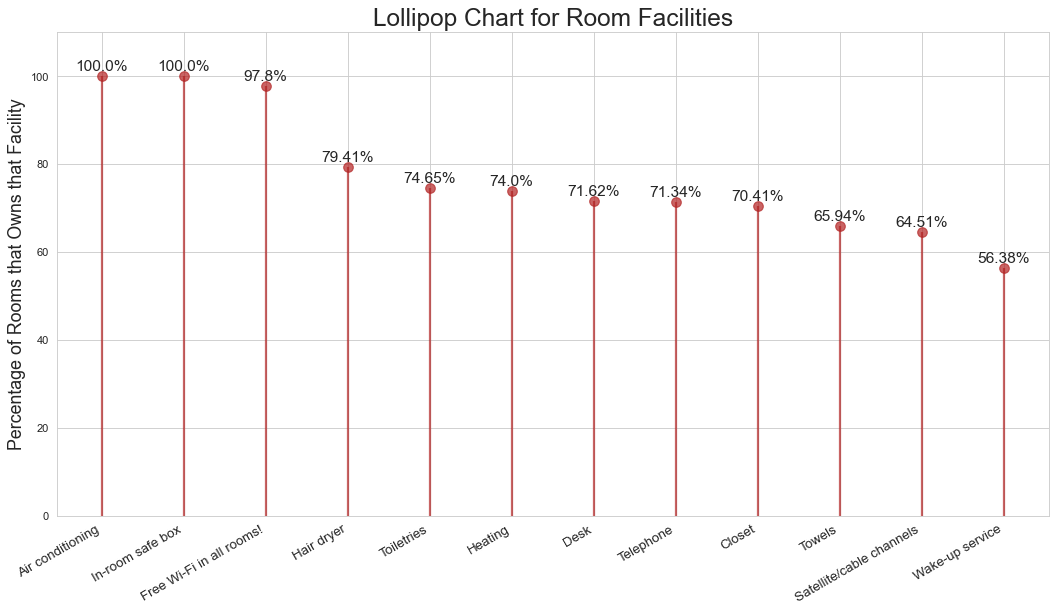

In [18]:
# Explore the roomamenities feature

# Split the offered items
content_roomamenities = df2['roomamenities'].str.split(';')

dict_roomamenities = {}
for i in content_roomamenities:
    for j in i:
        j = j.strip() # remove the space after each item
        j = j[:-1] # remove the ":" after each item
        if j in dict_roomamenities.keys():
            # count the frequency of each item
            dict_roomamenities[j] = dict_roomamenities[j]+1
        else:
            dict_roomamenities.update({j: 1})

pct_roomamenities = pd.Series(dict_roomamenities)

pct_roomamenities = pct_roomamenities.to_frame().reset_index()

pct_roomamenities.columns = ['Facility', 'Counts']

pct_roomamenities = pct_roomamenities.sort_values('Counts',ascending = False)

pct_roomamenities['Percentage'] = pct_roomamenities['Counts']/df2.shape[0]*100

pct_roomamenities = pct_roomamenities[(pct_roomamenities['Facility'] != '') & (pct_roomamenities['Percentage']>=50)]

pct_roomamenities = pct_roomamenities.reset_index().drop(columns = ['Counts','index'])

# Draw plot
fig, ax = plt.subplots(figsize=(16,8), dpi= 80)
ax.vlines(x=pct_roomamenities.index, 
          ymin=0, 
          ymax=pct_roomamenities.Percentage, 
          color='firebrick', 
          alpha=0.7, 
          linewidth=2)

ax.scatter(x=pct_roomamenities.index, 
           y=pct_roomamenities.Percentage, 
           s=75, 
           color='firebrick', 
           alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Lollipop Chart for Room Facilities', fontdict={'size':22})
ax.set_ylabel('Percentage of Rooms that Owns that Facility',fontdict={'size':16})
ax.set_xticks(pct_roomamenities.index)
ax.set_xticklabels(pct_roomamenities.Facility, 
                   rotation=30, 
                   fontdict={'horizontalalignment': 'right', 'size':12})

# Annotate
for row in pct_roomamenities.itertuples():
    ax.text(row.Index, 
            row.Percentage+.5, 
            s=f"{round(row.Percentage, 2)}%", 
            horizontalalignment= 'center', 
            verticalalignment='bottom', 
            fontsize=14)

ax.set_ylim(0, 110)


plt.show()

In [19]:
# Explore the feature ratedescription

description = df2['ratedescription']

# Extract the room size
room_size_ls = []

for i in description:
    
    if i.find("Room size:") == -1:
        room_size_ls.append(float('nan'))
    # find the descriptions that includes room size information
    else:
        room_size_ls.append(int(i.split('Room size:')[1].split('m²')[0].strip()))

room_size = pd.Series(room_size_ls)

# impute the missing values with mean
room_size.fillna(value=int(room_size.median()), inplace=True)

df2['Room_size'] = room_size

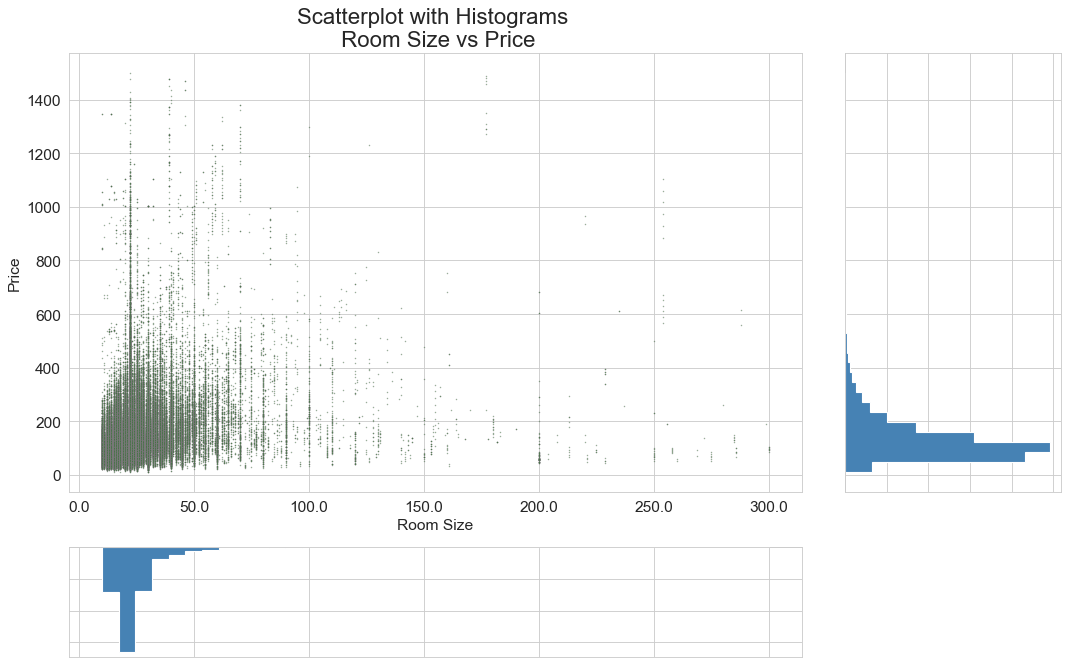

In [20]:
df = df2[['Room_size','price']]
df = df[df['price']<1500]

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_main.scatter('Room_size', 
                'price', 
                s=1, 
                c="darkgreen", 
                alpha=.4, 
                data=df, 
                cmap="tab10", 
                edgecolors='gray', 
                linewidths=.5)

# histogram on the right
ax_bottom.hist(df.Room_size, 40, histtype='stepfilled', orientation='vertical', color='steelblue')
ax_bottom.invert_yaxis()

# histogram in the bottom
ax_right.hist(df.price, 40, histtype='stepfilled', orientation='horizontal', color='steelblue')

# Decorations
ax_main.set(title='Scatterplot with Histograms \n Room Size vs Price', xlabel='Room Size', ylabel='Price')
ax_main.title.set_fontsize(20)
for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(14)

xlabels = ax_main.get_xticks().tolist()
ax_main.set_xticklabels(xlabels)
plt.show()

In [21]:
def check_existence(keyword):
    ls = []
    for i in description:
        if i.find(keyword) == -1:
            ls.append(False)
        else:
            ls.append(True)
    return pd.Series(ls)

df2['Has_Shower'] = check_existence("Shower")
df2['Non_Smoking'] = check_existence("Non-smoking")
df2['Has_Kitchenette'] = check_existence("Kitchenette")
df2['Has_City_view'] = check_existence("City view")
df2['Extra_low_price'] = check_existence("Extra low price")
df2['Free_WiFi'] = check_existence("Free Wi-Fi")
df2['Has_Single_Bed'] = check_existence("single bed")
df2['Has_Double_Bed'] = check_existence("double bed")
df2['Has_King_Bed'] = check_existence("king bed")
df2['Pay_After'] = check_existence("Pay nothing")

In [22]:
dict_description = {"Shower": sum(check_existence("Shower")),
                    "Non-Smoking":sum(check_existence("Non-smoking")),
                    "Kitchenette":sum(check_existence("Kitchenette")),
                    "City Biew":sum(check_existence("City view")),
                    "Extra Low Price":sum(check_existence("Extra low price")),
                    "Free Wi-Fi":sum(check_existence("Free Wi-Fi")),
                    "Single Bed":sum(check_existence("single bed")),
                    "Double bed":sum(check_existence("double bed")),
                    "King bed":sum(check_existence("king bed")),
                    "Pay After":sum(check_existence("Pay nothing")),
                   }

pct_description = (pd.Series(dict_description)/df2.shape[0] * 100).sort_values(ascending = False)

pct_description = pct_description.to_frame().reset_index()

pct_description.columns = ['Facility', 'Percentage']

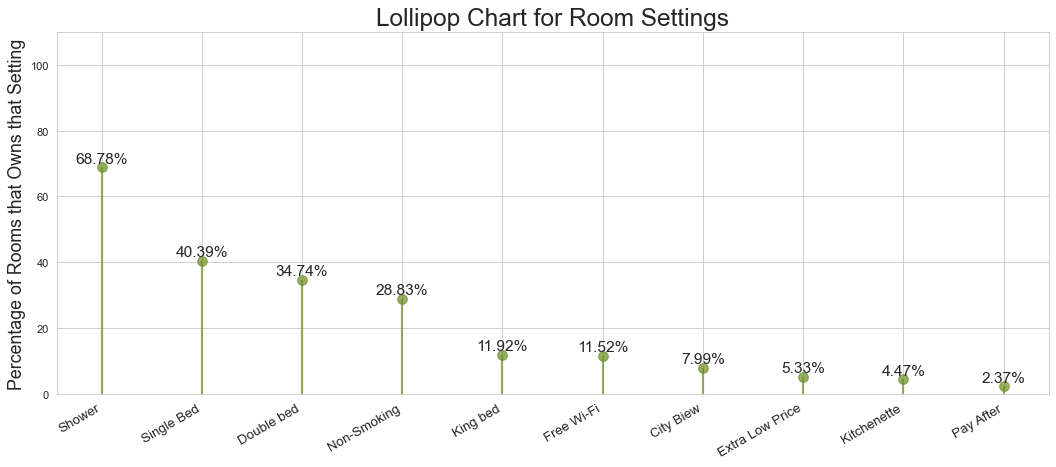

In [23]:
# Draw plot
fig, ax = plt.subplots(figsize=(16,6), dpi= 80)
ax.vlines(x=pct_description.index, 
          ymin=0, 
          ymax=pct_description.Percentage, 
          color='olivedrab', 
          alpha=0.7, 
          linewidth=2)

ax.scatter(x=pct_description.index, 
           y=pct_description.Percentage, 
           s=75, 
           color='olivedrab', 
           alpha=0.7)

# Title, Label, Ticks and Ylim
ax.set_title('Lollipop Chart for Room Settings', fontdict={'size':22})
ax.set_ylabel('Percentage of Rooms that Owns that Setting',fontdict={'size':16})
ax.set_xticks(pct_description.index)
ax.set_xticklabels(pct_description.Facility, 
                   rotation=30, 
                   fontdict={'horizontalalignment': 'right', 'size':12})

# Annotate
for row in pct_description.itertuples():
    ax.text(row.Index, 
            row.Percentage+.5, 
            s=f"{round(row.Percentage, 2)}%", 
            horizontalalignment= 'center', 
            verticalalignment='bottom', 
            fontsize=14)

ax.set_ylim(0, 110)


plt.show()

In [24]:
# Split the offered items
content_roomamenities = df2['roomamenities'].str.split(';')

dict_roomamenities = {}
for i in content_roomamenities:
    for j in i:
        j = j.strip() # remove the space after each item
        j = j[:-1] # remove the ":" after each item
        if j in dict_roomamenities.keys():
            # count the frequency of each item
            dict_roomamenities[j] = dict_roomamenities[j]+1
        else:
            dict_roomamenities.update({j: 1})

pct_roomamenities = pd.Series(dict_roomamenities)

pct_roomamenities = pct_roomamenities.to_frame().reset_index()

pct_roomamenities.columns = ['Facility', 'Counts']

pct_roomamenities = pct_roomamenities.sort_values('Counts',ascending = False)

pct_roomamenities['Percentage'] = pct_roomamenities['Counts']/df2.shape[0]*100

# Choose the room amenities that are not widely existing but not too rare
pct_roomamenities = pct_roomamenities[(pct_roomamenities['Facility'] != '') & 
                                      (pct_roomamenities['Percentage']>=30) & 
                                      (pct_roomamenities['Percentage']<=70)]

facility_ls = pct_roomamenities['Facility'].unique()

def add_column(keyword):
    ls = []
    for i in df2['roomamenities']:
        
        if keyword in i:
            
            ls.append(True)
        else:
            ls.append(False)
    column_name = 'Has_'+keyword
    df2[column_name] = pd.Series(ls)
    
for i in facility_ls:
    add_column(i)

## Purchasing Behaviors

<Figure size 1280x640 with 0 Axes>

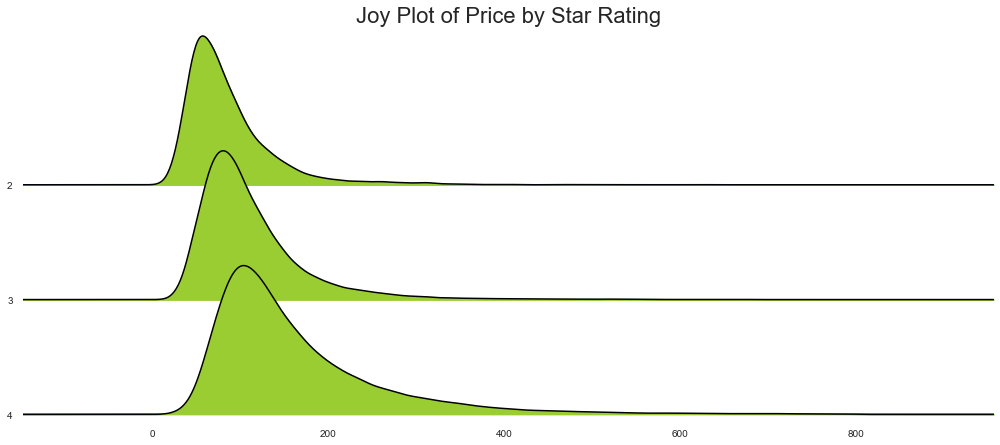

In [25]:
rating_price = df2[['starrating','price']]

rating_price = rating_price[rating_price['price']<800]

# Draw Plot
plt.figure(figsize=(16,8), dpi= 80)
fig, axes = joypy.joyplot(rating_price, 
                          column= ['price'], 
                          by="starrating", 
                          ylim='own', 
                          color = 'yellowgreen',
                          figsize=(14,6))

# Decoration
plt.title('Joy Plot of Price by Star Rating', fontsize=22)

plt.show()

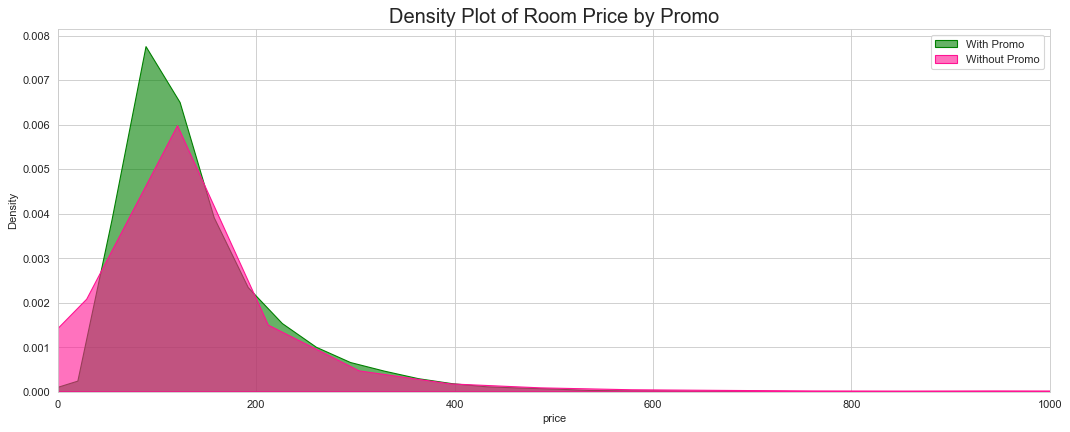

In [26]:
ispromo_price = df2[['ispromo', 'price']]

plt.figure(figsize=(16,6), dpi= 80)

sns.kdeplot(ispromo_price.loc[ispromo_price['ispromo'] == "Y", "price"], 
            shade=True, 
            color="g", 
            label="With Promo", 
            alpha=.6)

sns.kdeplot(ispromo_price.loc[ispromo_price['ispromo'] == "N", "price"], 
            shade=True, 
            color="deeppink", 
            label="Without Promo", 
            alpha=.6)

# Decoration
plt.title('Density Plot of Room Price by Promo', fontsize=18)

plt.xlim(0, 1000)

plt.legend()
plt.show()

## Find the distribution of target variable

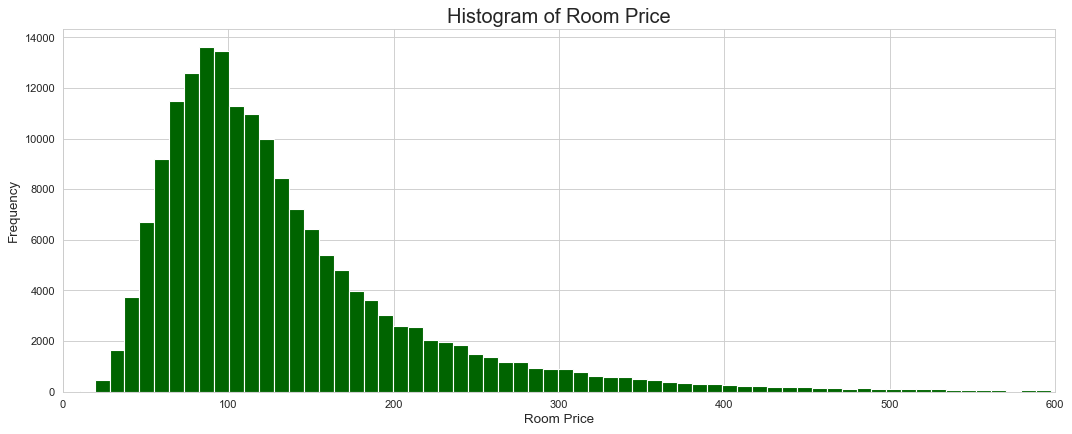

In [27]:
plt.figure(figsize=(16,6), dpi= 80)

df2['price'].hist(bins = 2000, 
                  color = 'darkgreen')

plt.ylabel('Frequency',fontsize=12)
plt.xlabel('Room Price',fontsize=12)

plt.xlim(0,600)

plt.title('Histogram of Room Price',fontsize=18)

plt.show()

## Create the dataset for training

In [28]:
# Drop the useless columns

df_final = df2.drop(columns = ['index','room_id','hotelcode', 
                               'hotelname','roomamenities','ratedescription'])
df_final

,roomtype,city,country,propertytype,starrating,latitude,longitude,Source,ispromo,maxoccupancy,...,Has_Towels,Has_Satellite/cable channels,Has_Wake-up service,Has_Coffee/tea maker,Has_Linens,Has_Smoke detector,Has_Carpeting,Has_Ironing facilities,Has_Mini bar,Has_Clothes rack
0,Double Room,Nether Stowey,United Kingdom,Hotels,4,51.150921,-3.158470,5,Y,1,...,True,False,False,True,True,False,True,True,True,False
1,Other Types,Beddgelert,United Kingdom,Hotels,3,53.042229,-4.033180,5,N,4,...,False,False,False,False,False,False,False,False,False,False
2,Other Types,Beverley,United Kingdom,Hotels,3,53.843220,-0.497970,5,N,4,...,False,False,False,False,False,False,False,False,False,False
3,Other Types,London,United Kingdom,Hotels,2,51.511234,-0.185117,5,N,1,...,False,True,False,True,False,False,False,False,False,True
4,Other Types,London,United Kingdom,Hotels,2,51.511234,-0.185117,5,N,3,...,False,True,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176101,Twin Room,Newcastle-upon-Tyne,United Kingdom,Hotels,3,54.972672,-1.634396,5,N,2,...,True,True,True,True,True,True,True,True,False,False
176102,Twin Room,Newcastle-upon-Tyne,United Kingdom,Hotels,3,54.972672,-1.634396,5,N,2,...,True,True,True,True,True,True,True,True,False,False
176103,Twin Room,Newcastle-upon-Tyne,United Kingdom,Hotels,3,54.972672,-1.634396,5,N,2,...,True,True,True,True,True,True,True,True,False,False
176104,Other Types,Newcastle-upon-Tyne,United Kingdom,Hotels,3,54.972672,-1.634396,5,N,1,...,False,False,False,False,False,False,False,False,False,False
